#**ARI_HISTORICAL_DATA**

### **Thuật toán AAE**

In [323]:
dataset = pd.read_csv('/content/ARE-Historical-Data.csv')

In [324]:
scaler=MinMaxScaler(feature_range=(0,1))

df1 = dataset.reset_index()['Price']

df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

# 4. Chia train test
data_transform_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - data_transform_size - test_size

data_transform = df1[:data_transform_size]
test_data = df1[data_transform_size:data_transform_size+test_size]
val_data = df1[data_transform_size+test_size:]

In [325]:
data_transform

array([[0.04492894],
       [0.01844823],
       [0.02806956],
       ...,
       [0.28802189],
       [0.29614264],
       [0.27707653]])

In [326]:
data_transform.shape

(1057, 1)

In [327]:
data_transform

array([[0.04492894],
       [0.01844823],
       [0.02806956],
       ...,
       [0.28802189],
       [0.29614264],
       [0.27707653]])

In [328]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch

# dùng 'gpu'.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

# số chiều không gian tiềm ẩn
latent_dim = 1

# số chiều vector đầu vào.
embedding = 1

# sampling từ trung bình và độ lệch chuẩn.
def reparameterization(mu, logvar):
    std = torch.exp(logvar / 2)
    sampled_z = Variable(torch.randn((mu.size(0), latent_dim))).to(device)
    z = sampled_z * std + mu
    return z

class Encoder(nn.Module):
    def __init__(self, embedding):
        super(Encoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(embedding, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.mu = nn.Linear(512, latent_dim)
        self.logvar = nn.Linear(512, latent_dim)

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        x = self.model(img_flat)
        mu = self.mu(x)
        logvar = self.logvar(x)
        z = reparameterization(mu, logvar)
        return z


class Decoder(nn.Module):
    def __init__(self, embedding):
        super(Decoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, embedding),
            nn.Tanh(),
        )

    def forward(self, z):
        img_flat = self.model(z)
        img = img_flat.view(img_flat.shape[0], -1)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        validity = self.model(z)
        return validity




In [329]:
batch_size=512
n_epochs = 100

In [330]:
# Chuẩn bị dữ liệu huấn luyện (torch dùng đc gpu, numpy -> cpu)
tensor_data = torch.from_numpy(data_transform).float()  # Chuyển đổi thành Tensor và kiểu dữ liệu float

# Tạo DataLoader
data_loader = DataLoader(tensor_data, batch_size=batch_size, shuffle=False)

In [331]:
# Use binary cross-entropy loss
adversarial_loss = torch.nn.BCELoss().to(device)
pixelwise_loss = torch.nn.L1Loss().to(device)

# Initialize generator and discriminator
encoder = Encoder(embedding).to(device)
decoder = Decoder(embedding).to(device)
discriminator = Discriminator().to(device)


In [332]:
# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(encoder.parameters(), decoder.parameters()), lr=0.0005
)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.00005)

In [333]:
# Khởi tạo list để lưu loss
d_losses = []
g_losses = []

for epoch in range(n_epochs):
    for i, imgs in enumerate(data_loader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor)).to(device)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()
        # print(real_imgs.shape)
        encoded_imgs = encoder(real_imgs)
        decoded_imgs = decoder(encoded_imgs)

        # Loss measures generator's ability to fool the discriminator
        g_loss = 0.001 * adversarial_loss(discriminator(encoded_imgs), valid) + 0.999 * pixelwise_loss(
            decoded_imgs, real_imgs
        )

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as discriminator ground truth
        z = Variable(Tensor(np.random.normal(0, 1, (real_imgs.shape[0], latent_dim))))

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(z), valid)
        fake_loss = adversarial_loss(discriminator(encoded_imgs.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        if (epoch + 1) % 5 == 0:
          print(
              "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
              % (epoch, n_epochs, i, len(data_loader), d_loss.item(), g_loss.item())
          )

[Epoch 4/100] [Batch 0/3] [D loss: 0.646137] [G loss: 0.138631]
[Epoch 4/100] [Batch 1/3] [D loss: 0.648489] [G loss: 0.096073]
[Epoch 4/100] [Batch 2/3] [D loss: 0.655445] [G loss: 0.177950]
[Epoch 9/100] [Batch 0/3] [D loss: 0.574978] [G loss: 0.157100]
[Epoch 9/100] [Batch 1/3] [D loss: 0.589421] [G loss: 0.077013]
[Epoch 9/100] [Batch 2/3] [D loss: 0.585216] [G loss: 0.145417]
[Epoch 14/100] [Batch 0/3] [D loss: 0.506034] [G loss: 0.101676]
[Epoch 14/100] [Batch 1/3] [D loss: 0.543726] [G loss: 0.046672]
[Epoch 14/100] [Batch 2/3] [D loss: 0.528864] [G loss: 0.144078]
[Epoch 19/100] [Batch 0/3] [D loss: 0.431523] [G loss: 0.111995]
[Epoch 19/100] [Batch 1/3] [D loss: 0.479197] [G loss: 0.057372]
[Epoch 19/100] [Batch 2/3] [D loss: 0.526282] [G loss: 0.118445]
[Epoch 24/100] [Batch 0/3] [D loss: 0.398840] [G loss: 0.110606]
[Epoch 24/100] [Batch 1/3] [D loss: 0.475631] [G loss: 0.048669]
[Epoch 24/100] [Batch 2/3] [D loss: 0.509472] [G loss: 0.086488]
[Epoch 29/100] [Batch 0/3] [D l

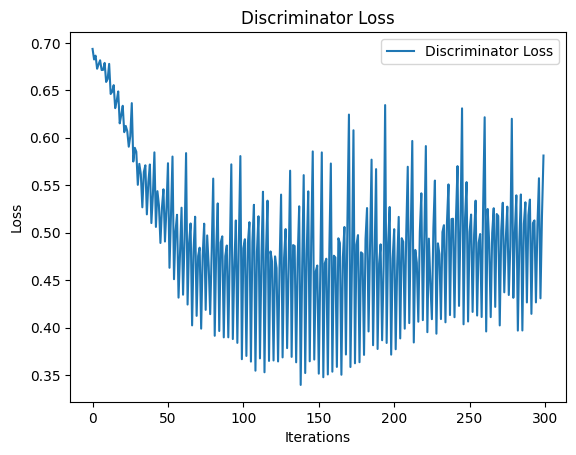

In [334]:
import matplotlib.pyplot as plt
# Vẽ biểu đồ Discriminator Loss
plt.plot(range(len(d_losses)), d_losses, label='Discriminator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Discriminator Loss')
plt.show()


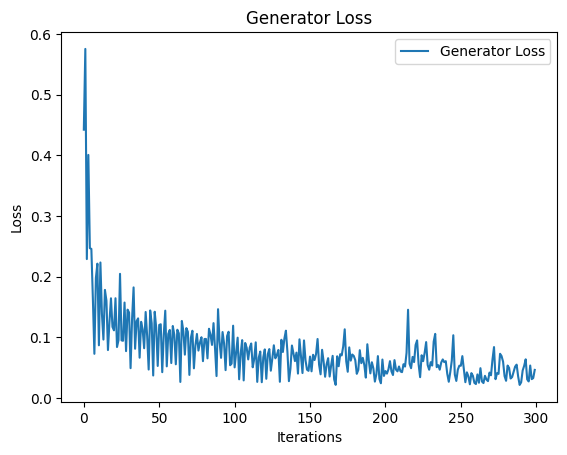

In [335]:
# Vẽ biểu đồ Generator Loss
plt.plot(range(len(g_losses)), g_losses, label='Generator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Generator Loss')
plt.show()

In [336]:
# Chuyển đổi dữ liệu thành tensor
tensor_data = torch.tensor(data_transform, dtype=torch.float32).to(device)
latent_vectors = encoder(tensor_data)

# reconstructed_data = decoder(latent_vectors)

# # Chuyển đổi dữ liệu mới thành dạng ban đầu
# generated_data = reconstructed_data.cpu().detach().numpy()


### **Thuật toán LSTM**

In [337]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [338]:
# 4. Chia train test
train_size = len(latent_vectors)
train_data = latent_vectors


In [339]:
scaler=MinMaxScaler(feature_range=(0,1))
train_data=scaler.fit_transform(np.array(train_data.detach().numpy()).reshape(-1,1))

In [340]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [341]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [342]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [343]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [344]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 11s 343ms/step - loss: 0.1415 - val_loss: 0.0111
Epoch 2/100
15/15 [==============================] - 4s 282ms/step - loss: 0.0192 - val_loss: 0.0324
Epoch 3/100
15/15 [==============================] - 3s 212ms/step - loss: 0.0095 - val_loss: 0.0306
Epoch 4/100
15/15 [==============================] - 3s 214ms/step - loss: 0.0081 - val_loss: 0.0199
Epoch 5/100
15/15 [==============================] - 4s 278ms/step - loss: 0.0070 - val_loss: 0.0124
Epoch 6/100
15/15 [==============================] - 6s 343ms/step - loss: 0.0064 - val_loss: 0.0067
Epoch 7/100
15/15 [==============================] - 3s 213ms/step - loss: 0.0058 - val_loss: 0.0035
Epoch 8/100
15/15 [==============================] - 3s 213ms/step - loss: 0.0056 - val_loss: 0.0029
Epoch 9/100
15/15 [==============================] - 4s 287ms/step - loss: 0.0053 - val_loss: 0.0028
Epoch 10/100
15/15 [==============================] - 4s 259ms/step - loss: 0.0053 - val_l

In [345]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)


2/2 [==============================] - 0s 61ms/step


In [346]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [347]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 7.369624271703529
Testing RMSE: 7.028291176174321


In [348]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, 91,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.13276857]
92
[0.13276857]
93
[0.13276857]
94
[0.13276857]
95
[0.13276857]
96
[0.13276857]
97
[0.13276857]
98
[0.13276857]
99
[0.13276857]
100
[0.13276857]
101
10 day input [0.10177421 0.09427134 0.08976962 0.08915173 0.08588578 0.07626445
 0.07467561 0.0767058  0.06355371 0.06425986 0.07838291 0.07520523
 0.06867332 0.07997175 0.08006002 0.08579751 0.08950481 0.0903875
 0.09312384 0.08085444 0.08579751 0.0889752  0.08014829 0.0866802
 0.08924    0.08976962 0.09727249 0.09736076 0.08050137 0.07388119
 0.07961868 0.09012269 0.09700768 0.09418307 0.08632713 0.09541884
 0.08588578 0.10053844 0.10256863 0.09886133 0.10115632 0.0818254
 0.08482655 0.09312384 0.09127019 0.09091712 0.09118192 0.0926825
 0.0903875  0.09471268 0.09683114 0.08932827 0.09330038 0.09303557
 0.08703328 0.0903875  0.09462442 0.1040692  0.10424574 0.09197634
 0.09577191 0.08615059 0.07458734 0.07750022 0.06681967 0.06117045
 0.07282196 0.06946774 0.08888693 0.09418307 0.08994616 0.07688234
 0.09047577 0.09992056 0.

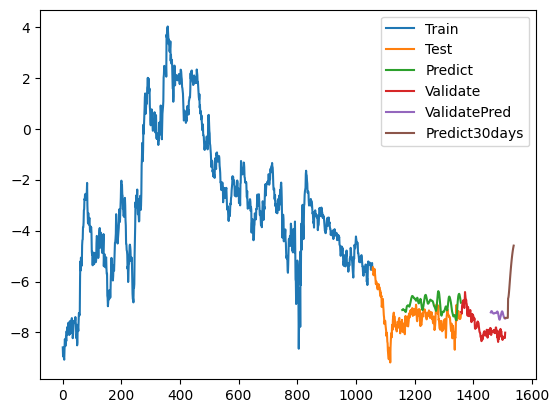

In [349]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(data_transform))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

#**MAA_HISTORICAL_DATA**

### **Thuật toán AAE**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import math
import itertools

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [ ]:
dataset = pd.read_csv('/content/MAA-Historical-Data.csv')

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))

df1 = dataset.reset_index()['Price']

df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

# 4. Chia train test
data_transform_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - data_transform_size - test_size

data_transform = df1[:data_transform_size]
test_data = df1[data_transform_size:data_transform_size+test_size]
val_data = df1[data_transform_size+test_size:]

In [ ]:
data_transform

array([[0.45582648],
       [0.4299924 ],
       [0.43095945],
       ...,
       [0.16626373],
       [0.16992471],
       [0.16453685]])

In [ ]:
data_transform.shape

(1057, 1)

In [ ]:
data_transform

array([[0.45582648],
       [0.4299924 ],
       [0.43095945],
       ...,
       [0.16626373],
       [0.16992471],
       [0.16453685]])

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch

# dùng 'gpu'.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

# số chiều không gian tiềm ẩn
latent_dim = 1

# số chiều vector đầu vào.
embedding = 1

# sampling từ trung bình và độ lệch chuẩn.
def reparameterization(mu, logvar):
    std = torch.exp(logvar / 2)
    sampled_z = Variable(torch.randn((mu.size(0), latent_dim))).to(device)
    z = sampled_z * std + mu
    return z

class Encoder(nn.Module):
    def __init__(self, embedding):
        super(Encoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(embedding, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.mu = nn.Linear(512, latent_dim)
        self.logvar = nn.Linear(512, latent_dim)

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        x = self.model(img_flat)
        mu = self.mu(x)
        logvar = self.logvar(x)
        z = reparameterization(mu, logvar)
        return z


class Decoder(nn.Module):
    def __init__(self, embedding):
        super(Decoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, embedding),
            nn.Tanh(),
        )

    def forward(self, z):
        img_flat = self.model(z)
        img = img_flat.view(img_flat.shape[0], -1)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        validity = self.model(z)
        return validity




In [ ]:
batch_size=512
n_epochs = 100

In [ ]:
# Chuẩn bị dữ liệu huấn luyện (torch dùng đc gpu, numpy -> cpu)
tensor_data = torch.from_numpy(data_transform).float()  # Chuyển đổi thành Tensor và kiểu dữ liệu float

# Tạo DataLoader
data_loader = DataLoader(tensor_data, batch_size=batch_size, shuffle=False)

In [ ]:
# Use binary cross-entropy loss
adversarial_loss = torch.nn.BCELoss().to(device)
pixelwise_loss = torch.nn.L1Loss().to(device)

# Initialize generator and discriminator
encoder = Encoder(embedding).to(device)
decoder = Decoder(embedding).to(device)
discriminator = Discriminator().to(device)


In [ ]:
# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(encoder.parameters(), decoder.parameters()), lr=0.0005
)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.00005)

In [ ]:
# Khởi tạo list để lưu loss
d_losses = []
g_losses = []

for epoch in range(n_epochs):
    for i, imgs in enumerate(data_loader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor)).to(device)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()
        # print(real_imgs.shape)
        encoded_imgs = encoder(real_imgs)
        decoded_imgs = decoder(encoded_imgs)

        # Loss measures generator's ability to fool the discriminator
        g_loss = 0.001 * adversarial_loss(discriminator(encoded_imgs), valid) + 0.999 * pixelwise_loss(
            decoded_imgs, real_imgs
        )

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as discriminator ground truth
        z = Variable(Tensor(np.random.normal(0, 1, (real_imgs.shape[0], latent_dim))))

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(z), valid)
        fake_loss = adversarial_loss(discriminator(encoded_imgs.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        if (epoch + 1) % 5 == 0:
          print(
              "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
              % (epoch, n_epochs, i, len(data_loader), d_loss.item(), g_loss.item())
          )

[Epoch 4/100] [Batch 0/3] [D loss: 0.653315] [G loss: 0.277914]
[Epoch 4/100] [Batch 1/3] [D loss: 0.649163] [G loss: 0.143642]
[Epoch 4/100] [Batch 2/3] [D loss: 0.661672] [G loss: 0.349421]
[Epoch 9/100] [Batch 0/3] [D loss: 0.607470] [G loss: 0.153119]
[Epoch 9/100] [Batch 1/3] [D loss: 0.619865] [G loss: 0.107805]
[Epoch 9/100] [Batch 2/3] [D loss: 0.690751] [G loss: 0.087449]
[Epoch 14/100] [Batch 0/3] [D loss: 0.575606] [G loss: 0.118537]
[Epoch 14/100] [Batch 1/3] [D loss: 0.587265] [G loss: 0.071271]
[Epoch 14/100] [Batch 2/3] [D loss: 0.629100] [G loss: 0.220164]
[Epoch 19/100] [Batch 0/3] [D loss: 0.533717] [G loss: 0.133015]
[Epoch 19/100] [Batch 1/3] [D loss: 0.569486] [G loss: 0.116040]
[Epoch 19/100] [Batch 2/3] [D loss: 0.671073] [G loss: 0.107448]
[Epoch 24/100] [Batch 0/3] [D loss: 0.489879] [G loss: 0.079481]
[Epoch 24/100] [Batch 1/3] [D loss: 0.516770] [G loss: 0.181773]
[Epoch 24/100] [Batch 2/3] [D loss: 0.616812] [G loss: 0.151614]
[Epoch 29/100] [Batch 0/3] [D l

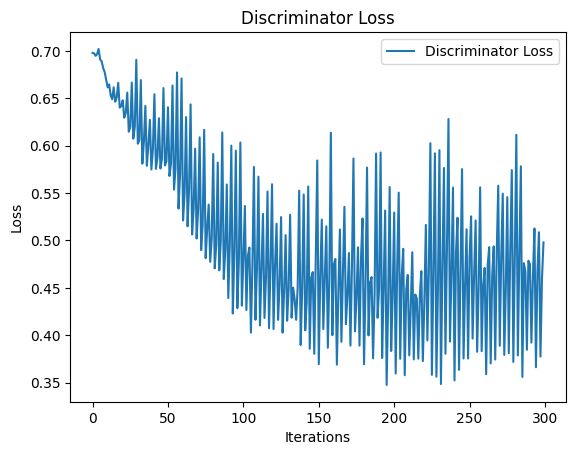

In [ ]:
import matplotlib.pyplot as plt
# Vẽ biểu đồ Discriminator Loss
plt.plot(range(len(d_losses)), d_losses, label='Discriminator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Discriminator Loss')
plt.show()


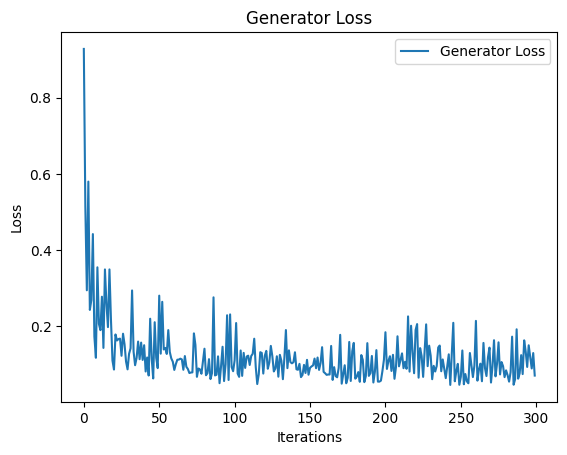

In [ ]:
# Vẽ biểu đồ Generator Loss
plt.plot(range(len(g_losses)), g_losses, label='Generator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Generator Loss')
plt.show()

In [ ]:
# Chuyển đổi dữ liệu thành tensor
tensor_data = torch.tensor(data_transform, dtype=torch.float32).to(device)
latent_vectors = encoder(tensor_data)

# reconstructed_data = decoder(latent_vectors)

# # Chuyển đổi dữ liệu mới thành dạng ban đầu
# generated_data = reconstructed_data.cpu().detach().numpy()


### **Thuật toán LSTM**

In [ ]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
# 4. Chia train test
train_size = len(latent_vectors)
train_data = latent_vectors


In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
train_data=scaler.fit_transform(np.array(train_data.detach().numpy()).reshape(-1,1))

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 13s 377ms/step - loss: 0.0521 - val_loss: 0.0069
Epoch 2/100
15/15 [==============================] - 3s 204ms/step - loss: 0.0073 - val_loss: 0.0211
Epoch 3/100
15/15 [==============================] - 5s 326ms/step - loss: 0.0039 - val_loss: 0.0256
Epoch 4/100
15/15 [==============================] - 3s 210ms/step - loss: 0.0037 - val_loss: 0.0227
Epoch 5/100
15/15 [==============================] - 3s 205ms/step - loss: 0.0034 - val_loss: 0.0198
Epoch 6/100
15/15 [==============================] - 3s 204ms/step - loss: 0.0033 - val_loss: 0.0186
Epoch 7/100
15/15 [==============================] - 5s 315ms/step - loss: 0.0033 - val_loss: 0.0188
Epoch 8/100
15/15 [==============================] - 3s 224ms/step - loss: 0.0033 - val_loss: 0.0174
Epoch 9/100
15/15 [==============================] - 3s 206ms/step - loss: 0.0033 - val_loss: 0.0168
Epoch 10/100
15/15 [==============================] - 3s 202ms/step - loss: 0.0033 - val_l

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)


2/2 [==============================] - 0s 37ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 30.32203053087128
Testing RMSE: 34.43005595893021


In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, 91,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.19921015]
92
[0.19921015]
93
[0.19921015]
94
[0.19921015]
95
[0.19921015]
96
[0.19921015]
97
[0.19921015]
98
[0.19921015]
99
[0.19921015]
100
[0.19921015]
101
10 day input [0.16474408 0.16350073 0.16066865 0.16294812 0.16032327 0.15548802
 0.15562617 0.15341576 0.14726808 0.14768253 0.15500449 0.15362299
 0.15534987 0.15610969 0.15631692 0.15907992 0.16294812 0.16267182
 0.15431374 0.14906403 0.15465911 0.16881951 0.16073772 0.15445189
 0.14989293 0.15072183 0.14885681 0.15051461 0.15161981 0.1458175
 0.14961663 0.15486634 0.15749119 0.15852732 0.15348484 0.15735304
 0.14574843 0.15092906 0.15210334 0.15493541 0.14871866 0.13366029
 0.13683774 0.14105132 0.13600884 0.13366029 0.13186434 0.13310769
 0.13248601 0.13269324 0.13027561 0.13151896 0.12592388 0.12136492
 0.11563169 0.12046695 0.11411204 0.11286869 0.11487187 0.11224701
 0.11445742 0.10872418 0.10409615 0.10471783 0.10306003 0.11024384
 0.1222629  0.11659874 0.14264005 0.1466464  0.1430545  0.14457415
 0.14906403 0.15231056

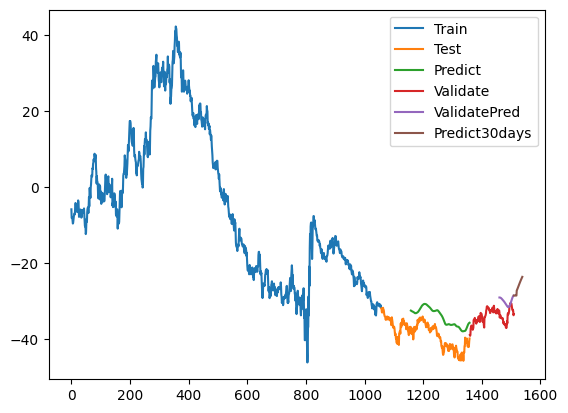

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(data_transform))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

#**ARI_HISTORICAL_DATA**

### **Thuật toán AAE**

In [296]:
dataset = pd.read_csv('/content/ARI-Historical-Data.csv')

In [297]:
scaler=MinMaxScaler(feature_range=(0,1))

df1 = dataset.reset_index()['Price']

df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

# 4. Chia train test
data_transform_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - data_transform_size - test_size

data_transform = df1[:data_transform_size]
test_data = df1[data_transform_size:data_transform_size+test_size]
val_data = df1[data_transform_size+test_size:]

In [298]:
data_transform

array([[0.42033679],
       [0.39572539],
       [0.37888601],
       ...,
       [0.92487047],
       [0.92551813],
       [0.91321244]])

In [299]:
data_transform.shape

(1057, 1)

In [300]:
data_transform

array([[0.42033679],
       [0.39572539],
       [0.37888601],
       ...,
       [0.92487047],
       [0.92551813],
       [0.91321244]])

In [301]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch

# dùng 'gpu'.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

# số chiều không gian tiềm ẩn
latent_dim = 1

# số chiều vector đầu vào.
embedding = 1

# sampling từ trung bình và độ lệch chuẩn.
def reparameterization(mu, logvar):
    std = torch.exp(logvar / 2)
    sampled_z = Variable(torch.randn((mu.size(0), latent_dim))).to(device)
    z = sampled_z * std + mu
    return z

class Encoder(nn.Module):
    def __init__(self, embedding):
        super(Encoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(embedding, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.mu = nn.Linear(512, latent_dim)
        self.logvar = nn.Linear(512, latent_dim)

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        x = self.model(img_flat)
        mu = self.mu(x)
        logvar = self.logvar(x)
        z = reparameterization(mu, logvar)
        return z


class Decoder(nn.Module):
    def __init__(self, embedding):
        super(Decoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, embedding),
            nn.Tanh(),
        )

    def forward(self, z):
        img_flat = self.model(z)
        img = img_flat.view(img_flat.shape[0], -1)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        validity = self.model(z)
        return validity




In [302]:
batch_size=512
n_epochs = 100

In [303]:
# Chuẩn bị dữ liệu huấn luyện (torch dùng đc gpu, numpy -> cpu)
tensor_data = torch.from_numpy(data_transform).float()  # Chuyển đổi thành Tensor và kiểu dữ liệu float

# Tạo DataLoader
data_loader = DataLoader(tensor_data, batch_size=batch_size, shuffle=False)

In [304]:
# Use binary cross-entropy loss
adversarial_loss = torch.nn.BCELoss().to(device)
pixelwise_loss = torch.nn.L1Loss().to(device)

# Initialize generator and discriminator
encoder = Encoder(embedding).to(device)
decoder = Decoder(embedding).to(device)
discriminator = Discriminator().to(device)


In [305]:
# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(encoder.parameters(), decoder.parameters()), lr=0.0005
)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.00005)

In [306]:
# Khởi tạo list để lưu loss
d_losses = []
g_losses = []

for epoch in range(n_epochs):
    for i, imgs in enumerate(data_loader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor)).to(device)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()
        # print(real_imgs.shape)
        encoded_imgs = encoder(real_imgs)
        decoded_imgs = decoder(encoded_imgs)

        # Loss measures generator's ability to fool the discriminator
        g_loss = 0.001 * adversarial_loss(discriminator(encoded_imgs), valid) + 0.999 * pixelwise_loss(
            decoded_imgs, real_imgs
        )

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as discriminator ground truth
        z = Variable(Tensor(np.random.normal(0, 1, (real_imgs.shape[0], latent_dim))))

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(z), valid)
        fake_loss = adversarial_loss(discriminator(encoded_imgs.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        if (epoch + 1) % 5 == 0:
          print(
              "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
              % (epoch, n_epochs, i, len(data_loader), d_loss.item(), g_loss.item())
          )

[Epoch 4/100] [Batch 0/3] [D loss: 0.700267] [G loss: 0.201237]
[Epoch 4/100] [Batch 1/3] [D loss: 0.673611] [G loss: 0.397608]
[Epoch 4/100] [Batch 2/3] [D loss: 0.660546] [G loss: 0.400039]
[Epoch 9/100] [Batch 0/3] [D loss: 0.640242] [G loss: 0.208857]
[Epoch 9/100] [Batch 1/3] [D loss: 0.630500] [G loss: 0.329103]
[Epoch 9/100] [Batch 2/3] [D loss: 0.645137] [G loss: 0.219168]
[Epoch 14/100] [Batch 0/3] [D loss: 0.628979] [G loss: 0.119262]
[Epoch 14/100] [Batch 1/3] [D loss: 0.614994] [G loss: 0.227046]
[Epoch 14/100] [Batch 2/3] [D loss: 0.615232] [G loss: 0.069177]
[Epoch 19/100] [Batch 0/3] [D loss: 0.631147] [G loss: 0.126982]
[Epoch 19/100] [Batch 1/3] [D loss: 0.613009] [G loss: 0.216704]
[Epoch 19/100] [Batch 2/3] [D loss: 0.627412] [G loss: 0.023480]
[Epoch 24/100] [Batch 0/3] [D loss: 0.644454] [G loss: 0.136670]
[Epoch 24/100] [Batch 1/3] [D loss: 0.624367] [G loss: 0.207488]
[Epoch 24/100] [Batch 2/3] [D loss: 0.631400] [G loss: 0.028184]
[Epoch 29/100] [Batch 0/3] [D l

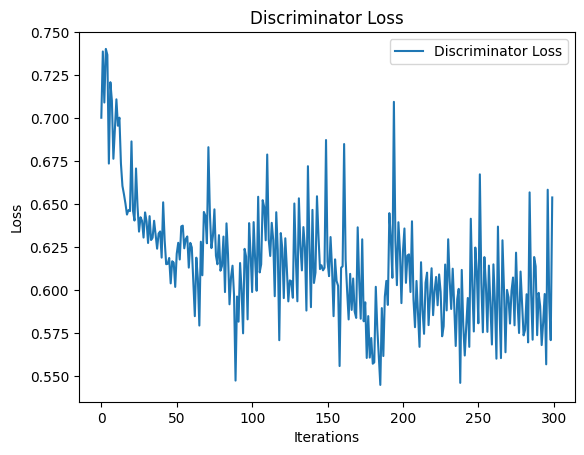

In [307]:
import matplotlib.pyplot as plt
# Vẽ biểu đồ Discriminator Loss
plt.plot(range(len(d_losses)), d_losses, label='Discriminator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Discriminator Loss')
plt.show()


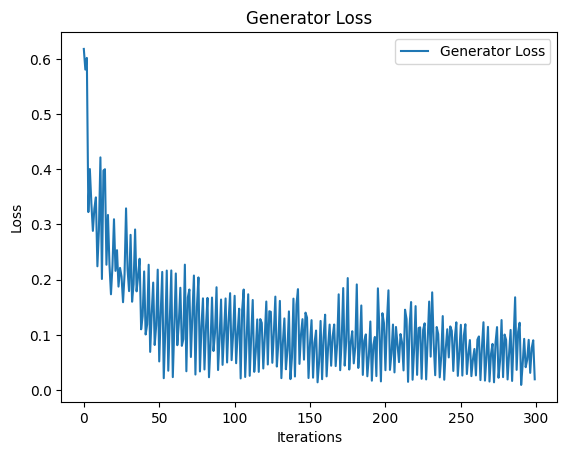

In [308]:
# Vẽ biểu đồ Generator Loss
plt.plot(range(len(g_losses)), g_losses, label='Generator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Generator Loss')
plt.show()

In [309]:
# Chuyển đổi dữ liệu thành tensor
tensor_data = torch.tensor(data_transform, dtype=torch.float32).to(device)
latent_vectors = encoder(tensor_data)

# reconstructed_data = decoder(latent_vectors)

# # Chuyển đổi dữ liệu mới thành dạng ban đầu
# generated_data = reconstructed_data.cpu().detach().numpy()


### **Thuật toán LSTM**

In [310]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [311]:
# 4. Chia train test
train_size = len(latent_vectors)
train_data = latent_vectors


In [312]:
scaler=MinMaxScaler(feature_range=(0,1))
train_data=scaler.fit_transform(np.array(train_data.detach().numpy()).reshape(-1,1))

In [313]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [314]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [315]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [316]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [317]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 13s 441ms/step - loss: 0.0264 - val_loss: 0.0784
Epoch 2/100
15/15 [==============================] - 3s 209ms/step - loss: 0.0039 - val_loss: 0.0712
Epoch 3/100
15/15 [==============================] - 3s 216ms/step - loss: 0.0026 - val_loss: 0.0579
Epoch 4/100
15/15 [==============================] - 3s 215ms/step - loss: 0.0024 - val_loss: 0.0502
Epoch 5/100
15/15 [==============================] - 5s 325ms/step - loss: 0.0023 - val_loss: 0.0510
Epoch 6/100
15/15 [==============================] - 3s 206ms/step - loss: 0.0023 - val_loss: 0.0535
Epoch 7/100
15/15 [==============================] - 4s 252ms/step - loss: 0.0023 - val_loss: 0.0527
Epoch 8/100
15/15 [==============================] - 4s 244ms/step - loss: 0.0023 - val_loss: 0.0555
Epoch 9/100
15/15 [==============================] - 5s 342ms/step - loss: 0.0023 - val_loss: 0.0622
Epoch 10/100
15/15 [==============================] - 4s 244ms/step - loss: 0.0023 - val_l

In [318]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)


2/2 [==============================] - 0s 42ms/step


In [319]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [320]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 26.198356439948274
Testing RMSE: 26.752785017087696


In [321]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, 91,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.63328326]
92
[0.63328326]
93
[0.63328326]
94
[0.63328326]
95
[0.63328326]
96
[0.63328326]
97
[0.63328326]
98
[0.63328326]
99
[0.63328326]
100
[0.63328326]
101
10 day input [0.90673575 0.90479275 0.90414508 0.90932642 0.90349741 0.90479275
 0.9015544  0.89831606 0.90090674 0.93588083 0.92810881 0.92163212
 0.9138601  0.90803109 0.90932642 0.90284974 0.89248705 0.8892487
 0.88471503 0.8873057  0.88601036 0.8892487  0.875      0.87759067
 0.88536269 0.88536269 0.90284974 0.89702073 0.87759067 0.87823834
 0.88471503 0.88082902 0.88212435 0.88277202 0.8873057  0.88406736
 0.88601036 0.88536269 0.89572539 0.89766839 0.90608808 0.88989637
 0.89507772 0.90414508 0.89572539 0.89183938 0.89183938 0.88665803
 0.88406736 0.88536269 0.89313472 0.88341969 0.88536269 0.89378238
 0.89378238 0.90414508 0.90608808 0.89831606 0.89119171 0.89183938
 0.90673575 0.91256477 0.90479275 0.91645078 0.91645078 0.90997409
 0.91256477 0.93134715 0.93911917 0.9384715  0.92681347 0.92810881
 0.93393782 0.95595855

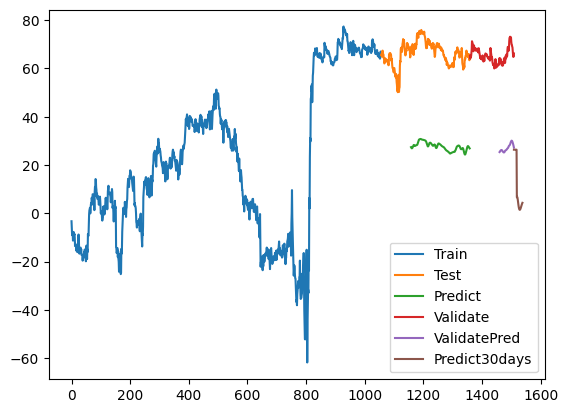

In [322]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(data_transform))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()